# Experimenting with PID tuning

In [1]:
import subprocess
import numpy as np
import time

## Running experiments and optimization on the simulator

Function to run experiments with specific parameters and under pre-determined conditions

In [2]:
def run_experiment(kp, ki, kd, speed, sample_size=-1, pid = './build/pid'):
    steering_PID_p = list()
    steering_PID_d = list()
    steering_PID_i = list()
    steering_PID_MSE = list()
    steering_PID_CAE = list()
    throttle_PID_p = list()
    throttle_PID_d = list()
    throttle_PID_i = list()
    throttle_PID_MSE = list()
    throttle_PID_CAE = list()
    actual_speed = list()
    steering_cte = list()
    steering_input = list()
    throttle_input = list()
    parameters = list(map(str,[kp, ki, kd, speed, sample_size]))
    result = subprocess.run([pid]+parameters, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8').split('\n')
    for line in output:
        data = line.split()
        if 'Steering PID >' in line:
            steering_PID_p.append(float(data[4]))
            steering_PID_d.append(float(data[6]))
            steering_PID_i.append(float(data[8]))
            steering_PID_MSE.append(float(data[10]))
            steering_PID_CAE.append(float(data[12]))
        if 'Throttle PID >' in line:
            throttle_PID_p.append(float(data[4]))
            throttle_PID_d.append(float(data[6]))
            throttle_PID_i.append(float(data[8]))
            throttle_PID_MSE.append(float(data[10]))
            throttle_PID_CAE.append(float(data[12]))
        if 'Speed:' in line:
            actual_speed.append(float(data[1]))
        if 'CTE:' in line:
            steering_cte.append(float(data[1]))
            steering_input.append(float(data[4]))
            throttle_input.append(float(data[7]))
    response = {
    'steering_PID_p': steering_PID_p,
    'steering_PID_d': steering_PID_d,
    'steering_PID_i': steering_PID_i,
    'steering_PID_MSE': steering_PID_MSE,
    'steering_PID_CAE': steering_PID_CAE,
    'throttle_PID_p': throttle_PID_p,
    'throttle_PID_d': throttle_PID_d,
    'throttle_PID_i': throttle_PID_i,
    'throttle_PID_MSE': throttle_PID_MSE,
    'throttle_PID_CAE': throttle_PID_CAE,
    'actual_speed': actual_speed,
    'steering_cte': steering_cte,
    'steering_input': steering_input,
    'throttle_input': throttle_input
           }
    return response    

Function to run the twiddle (coordinate ascent) optimization, as described in Prof. Sebastian Thrun's lessons.

In [3]:
def twiddle(p = [0, 0, 0], dp = [1, 1, 1], speed=50, sample_size=300, 
            increase=1.2, decrease=0.5, tol=0.2, measure="steering_PID_MSE"):

    feedback = run_experiment(p[0], p[1], p[2], speed, 5) # Resets the car's position
    time.sleep(5)
    feedback = run_experiment(p[0], p[1], p[2], speed, sample_size)
    best_err = (feedback[measure])[-1]
       
    it = 0
    exp_report = list()
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
        print("Kp %0.5f Ki %0.5f Kd %0.5f" % (p[0], p[1], p[2],))
        print("dKp %0.5f dKi %0.5f dKd %0.5f" % (dp[0], dp[1], dp[2],))
        if len(exp_report) >= 6:
            print("latest best result: %0.3f" % min(exp_report[-6:]))
        for i in range(len(p)):
            p[i] += dp[i]
            feedback = run_experiment(p[0], p[1], p[2], speed, sample_size)
            err = (feedback[measure])[-1]
            exp_report.append(err)
            print("TEST: Kp %0.5f Ki %0.5f Kd %0.5f > %0.3f" % (p[0], p[1], p[2], err))
            if err < best_err: # There was some improvement
                best_err = err
                dp[i] *= increase # We increase the step
            else: # There was no improvement
                p[i] -= 2 * dp[i] # Go into the other direction
                feedback = run_experiment(p[0], p[1], p[2], speed, sample_size)
                err = (feedback[measure])[-1]
                exp_report.append(err)
                print("TEST: Kp %0.5f Ki %0.5f Kd %0.5f > %0.3f" % (p[0], p[1], p[2], err))
                if err < best_err: # There was some improvement
                    best_err = err
                    dp[i] *= increase # We increase the step
                else: # There was no improvement
                    p[i] += dp[i]
                    dp[i] *= decrease
                    # As there was no improvement, the step size in either
                    # direction, the step size might simply be too big.
        it += 1
    return p


## Manual tuning

Repeating a few times increasing first Kp, then Kd in order to stabilize any overshooting. After working P and D have been found, try to increade I until the model holds.  

In [17]:
# Screen resolution: from 640x480 to 1024x768 - Graphics quality: fastest
best_err = 10**9
best_p_set = [0, 0, 0]
speed = 50
sample_size = 1500

In [18]:
kp = 0.3
ki = 0.001
kd = 3.0
feedback = run_experiment(kp, ki, kd, speed, sample_size)
err = feedback['steering_PID_MSE'][-1]
if err < best_err:
    print ("Found a better set of kp, ki & kd")
    print ("MSE: %0.3f" % err)
    best_err = err
    best_p_set = [kp, ki, kd]

Found a better set of kp, ki & kd
MSE: 0.249


## Automatic tuning

After tuning the setting by hand, thus providing a good guess, the twiddle algorithm will try to improve them

In [19]:
best_p_set = [0.3, 0.001, 3.0]
print ("Best coefficient set found by manual tuning:", best_p_set)

Best coefficient set found by manual tuning: [0.3, 0.001, 3.0]


In [20]:
speed = 50
sample_size = 1500
tuned = twiddle(p = best_p_set, dp = [k/2.0 for k in best_p_set], speed=speed, sample_size=sample_size, tol=0.1)

Iteration 0, best error = 0.222
Kp 0.30000 Ki 0.00100 Kd 3.00000
dKp 0.15000 dKi 0.00050 dKd 1.50000
TEST: Kp 0.45000 Ki 0.00100 Kd 3.00000 > 0.216
TEST: Kp 0.45000 Ki 0.00150 Kd 3.00000 > 0.297
TEST: Kp 0.45000 Ki 0.00050 Kd 3.00000 > 0.347
TEST: Kp 0.45000 Ki 0.00100 Kd 4.50000 > 0.337
TEST: Kp 0.45000 Ki 0.00100 Kd 1.50000 > 99.300
Iteration 1, best error = 0.216
Kp 0.45000 Ki 0.00100 Kd 3.00000
dKp 0.18000 dKi 0.00025 dKd 0.75000
TEST: Kp 0.63000 Ki 0.00100 Kd 3.00000 > 39.800
TEST: Kp 0.27000 Ki 0.00100 Kd 3.00000 > 0.267
TEST: Kp 0.45000 Ki 0.00125 Kd 3.00000 > 0.213
TEST: Kp 0.45000 Ki 0.00125 Kd 3.75000 > 0.387
TEST: Kp 0.45000 Ki 0.00125 Kd 2.25000 > 0.762
Iteration 2, best error = 0.213
Kp 0.45000 Ki 0.00125 Kd 3.00000
dKp 0.09000 dKi 0.00030 dKd 0.37500
latest best result: 0.213
TEST: Kp 0.54000 Ki 0.00125 Kd 3.00000 > 0.718
TEST: Kp 0.36000 Ki 0.00125 Kd 3.00000 > 0.239
TEST: Kp 0.45000 Ki 0.00155 Kd 3.00000 > 0.462
TEST: Kp 0.45000 Ki 0.00095 Kd 3.00000 > 0.295
TEST: Kp 0.

## Visualization of tuning results

In [21]:
import pandas as pd
import matplotlib

In [22]:
%matplotlib inline

In [35]:
tuned = [0.35100, 0.00118, 3.00000]
print ("Best coefficient set found after twiddling (coordinate ascent):", tuned)

Best coefficient set found after twiddling (coordinate ascent): [0.351, 0.00118, 3.0]


In [48]:
sample_size = 1500
speed = 50
feedback = run_experiment(tuned[0], tuned[1], tuned[2], speed, sample_size)
err = feedback['steering_PID_MSE'][-1]
print ("MSE: %0.3f" % err)

MSE: 0.218


In [49]:
PID_response = pd.DataFrame(
    np.array(
    [np.array(feedback['steering_PID_p']) * tuned[0],
     np.array(feedback['steering_PID_i']) * tuned[1],
     np.array(feedback['steering_PID_d']) * tuned[2],
     np.array(feedback['steering_input']),
     np.array(feedback['steering_PID_MSE']),
     ]).T,
columns = ['p','i','d','response', 'mse'])

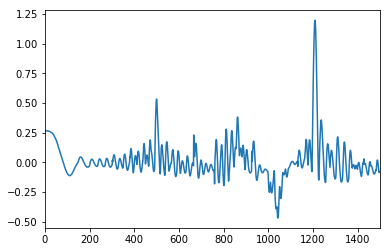

In [50]:
PID_response.p.plot()

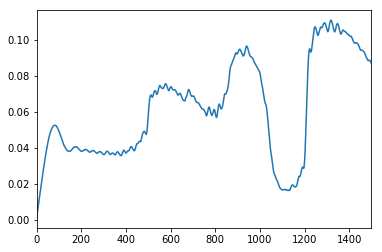

In [51]:
PID_response.i.plot()

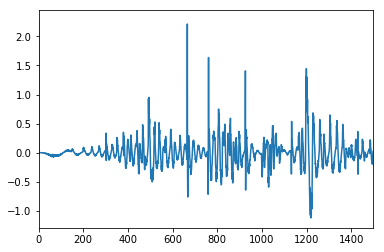

In [52]:
PID_response.d.plot()

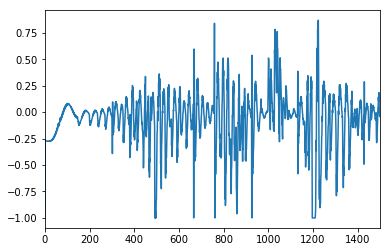

In [53]:
PID_response.response.plot()

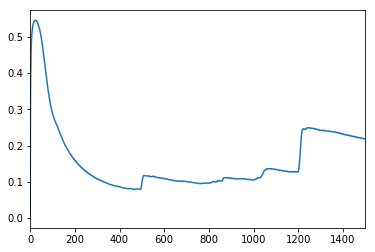

In [54]:
PID_response.mse.plot()